# Import Data and convert appropriate column to float

In [1]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ThuanSession').getOrCreate()

In [2]:
df= spark.read.option("header",True).csv("insurance.csv")

In [3]:
df.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|    33|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [4]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- children: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: string (nullable = true)



In [5]:
df=df.withColumn('age',df['age'].cast("float").alias('age'))
df=df.withColumn('bmi',df['bmi'].cast("float").alias('bmi'))
df=df.withColumn('children',df['children'].cast("float").alias('children'))
df=df.withColumn('charges',df['charges'].cast("float").alias('charges'))

In [6]:
df.printSchema()

root
 |-- age: float (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: float (nullable = true)
 |-- children: float (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: float (nullable = true)



# Data summary of numeric column

In [7]:
df.describe(['age','bmi','children','charges']).show()

+-------+------------------+-----------------+-----------------+------------------+
|summary|               age|              bmi|         children|           charges|
+-------+------------------+-----------------+-----------------+------------------+
|  count|              1338|             1338|             1338|              1338|
|   mean| 39.20702541106129|30.66339685599722|  1.0949177877429|13270.422259640089|
| stddev|14.049960379216147|6.098186944544972|1.205492739781914|12110.011235594102|
|    min|              18.0|            15.96|              0.0|         1121.8739|
|    max|              64.0|            53.13|              5.0|          63770.43|
+-------+------------------+-----------------+-----------------+------------------+



In [8]:
from pyspark.sql.functions import concat_ws,col
dfPlot = df.groupBy(["sex","smoker"]).count()
dfPlot=dfPlot.select(concat_ws(' ',df.sex,df.smoker).alias("Sex_Smoker"),"count")
dfPlot.show()

+----------+-----+
|Sex_Smoker|count|
+----------+-----+
|   male no|  517|
|  male yes|  159|
|female yes|  115|
| female no|  547|
+----------+-----+



In [9]:
import matplotlib.pyplot as plt
rows=dfPlot.toPandas()["Sex_Smoker"].values.tolist()
cols=dfPlot.toPandas()["count"].values.tolist()

Text(0.5, 1.0, 'Distribution of Smoker in data set')

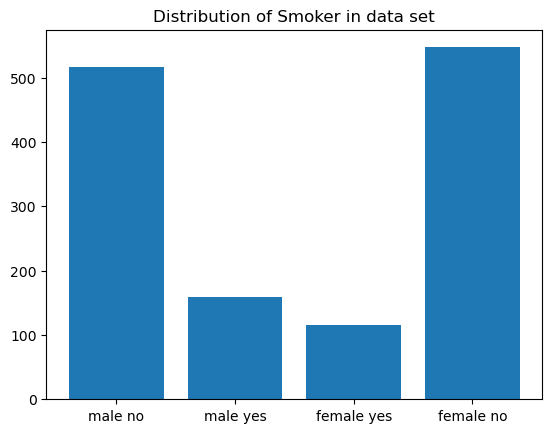

In [10]:
plt.bar(rows,cols)
plt.title("Distribution of Smoker in data set")

# Apply Label encoder to sex, smoker, region
- In this case:
    + Sex: male=0 female=1
    + smokerLabel: yes=1, no=0
- Region really should be one-hot encoded

In [11]:
from pyspark.ml.feature import StringIndexer

for col in ['sex','smoker','region']:
    Label_encoder=StringIndexer(inputCol=col,outputCol=col+"Label")
    df=Label_encoder.fit(df).transform(df)

df.show()

+----+------+------+--------+------+---------+---------+--------+-----------+-----------+
| age|   sex|   bmi|children|smoker|   region|  charges|sexLabel|smokerLabel|regionLabel|
+----+------+------+--------+------+---------+---------+--------+-----------+-----------+
|19.0|female|  27.9|     0.0|   yes|southwest|16884.924|     1.0|        1.0|        2.0|
|18.0|  male| 33.77|     1.0|    no|southeast|1725.5522|     0.0|        0.0|        0.0|
|28.0|  male|  33.0|     3.0|    no|southeast| 4449.462|     0.0|        0.0|        0.0|
|33.0|  male|22.705|     0.0|    no|northwest| 21984.47|     0.0|        0.0|        1.0|
|32.0|  male| 28.88|     0.0|    no|northwest|3866.8552|     0.0|        0.0|        1.0|
|31.0|female| 25.74|     0.0|    no|southeast|3756.6216|     1.0|        0.0|        0.0|
|46.0|female| 33.44|     1.0|    no|southeast|  8240.59|     1.0|        0.0|        0.0|
|37.0|female| 27.74|     3.0|    no|northwest|7281.5054|     1.0|        0.0|        1.0|
|37.0|  ma

In [12]:
df.select('regionLabel').distinct().collect()

[Row(regionLabel=0.0),
 Row(regionLabel=1.0),
 Row(regionLabel=3.0),
 Row(regionLabel=2.0)]

In [13]:
df.select('region').distinct().collect()

[Row(region='northwest'),
 Row(region='southeast'),
 Row(region='northeast'),
 Row(region='southwest')]

# Create BoxPlot to explore the outlier for the charges

In [14]:
df_pandas=df.toPandas()

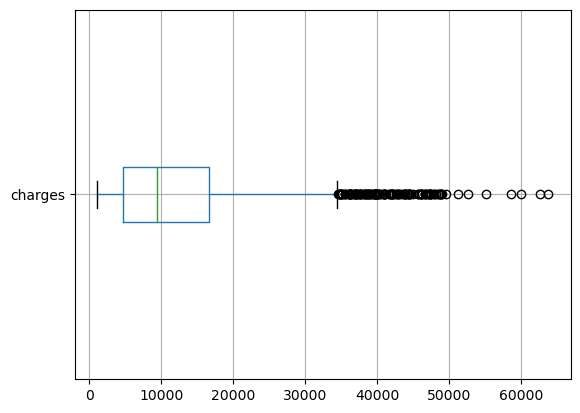

In [15]:
df_pandas.boxplot(column=['charges'],vert=False)
plt.show()

In [16]:
def outlier(df,feature):
    Q1=df[feature].quantile(0.25)
    Q3=df[feature].quantile(0.75)
    IQR = Q3-Q1
    
    lower_bound=Q1 - 1.5 *IQR
    upper_bound = Q3+1.5*IQR
    
    outlier_list=df.index[(df[feature]<lower_bound) | (df[feature]>upper_bound)]
    
    return (outlier_list,lower_bound,upper_bound)

In [17]:
temp=outlier(df_pandas,'charges')
charges_outlier_index=temp[0]
upper_bound=temp[2]
lower_bound=temp[1]
print("There are",len(charges_outlier_index),"outliers out of", len(df_pandas.index),f'which is {len(charges_outlier_index)/len(df_pandas.index)*100}%')

There are 139 outliers out of 1338 which is 10.388639760837071%


In [18]:
#Outlier removal steps
df_pandas=df_pandas.drop(charges_outlier_index)

In [19]:
df_pandas.describe()

,age,bmi,children,charges,sexLabel,smokerLabel,regionLabel
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,38.989990,30.095196,1.084237,9927.747070,0.510425,0.115096,1.480400
std,14.068043,6.010550,1.214303,7241.158691,0.500100,0.319271,1.120938
min,18.000000,15.960000,0.000000,1121.873901,0.000000,0.000000,0.000000
25%,26.000000,25.799999,0.000000,4408.695801,0.000000,0.000000,0.000000
50%,39.000000,29.735001,1.000000,8410.046875,1.000000,0.000000,1.000000
75%,51.000000,33.820000,2.000000,12953.594727,1.000000,0.000000,2.000000
max,64.000000,53.130001,5.000000,34472.839844,1.000000,1.000000,3.000000


In [20]:
df = df.filter((df.charges<upper_bound) & (df.charges>lower_bound))

In [21]:
df.describe(['age','bmi','children','charges']).show()

+-------+------------------+------------------+------------------+-----------------+
|summary|               age|               bmi|          children|          charges|
+-------+------------------+------------------+------------------+-----------------+
|  count|              1199|              1199|              1199|             1199|
|   mean| 38.98999165971643|30.095200153665804|1.0842368640533777|9927.753397199489|
| stddev|14.068040002043485|   6.0105513761724|1.2143040343155822| 7241.15829369412|
|    min|              18.0|             15.96|               0.0|        1121.8739|
|    max|              64.0|             53.13|               5.0|         34472.84|
+-------+------------------+------------------+------------------+-----------------+



# Create feature columns to get ready for linear regression:

In [22]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Assembler = VectorAssembler(inputCols=['age','sexLabel','smokerLabel','regionLabel',
                                       'bmi','children'],
                           outputCol='features')
df=Assembler.transform(df)

In [23]:
df_train_test=df.select('features','charges')

In [24]:
df_train_test.show()

+--------------------+---------+
|            features|  charges|
+--------------------+---------+
|[19.0,1.0,1.0,2.0...|16884.924|
|[18.0,0.0,0.0,0.0...|1725.5522|
|[28.0,0.0,0.0,0.0...| 4449.462|
|[33.0,0.0,0.0,1.0...| 21984.47|
|[32.0,0.0,0.0,1.0...|3866.8552|
|[31.0,1.0,0.0,0.0...|3756.6216|
|[46.0,1.0,0.0,0.0...|  8240.59|
|[37.0,1.0,0.0,1.0...|7281.5054|
|[37.0,0.0,0.0,3.0...|6406.4106|
|[60.0,1.0,0.0,1.0...|28923.137|
|[25.0,0.0,0.0,3.0...|2721.3208|
|[62.0,1.0,1.0,0.0...|27808.725|
|[23.0,0.0,0.0,2.0...| 1826.843|
|[56.0,1.0,0.0,0.0...|11090.718|
|[19.0,0.0,0.0,2.0...| 1837.237|
|[52.0,1.0,0.0,3.0...|10797.336|
|[23.0,0.0,0.0,3.0...|2395.1716|
|[56.0,0.0,0.0,2.0...|10602.385|
|[60.0,1.0,0.0,3.0...|13228.847|
|[30.0,1.0,0.0,2.0...| 4149.736|
+--------------------+---------+
only showing top 20 rows



In [25]:
model_list=[]

In [26]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import rand 
import timeit

folds=10

performance_metrics=[('r2','Regression through the origin')]

columns_name=['Name','Itteration']
for p_metrics in performance_metrics:
    columns_name.append(p_metrics[0])

performance_df = pd.DataFrame(columns = columns_name)
model_list=[]
#Fit with linear regression model:
linear_reg = LinearRegression(featuresCol="features", labelCol="charges")
model_list.append(('linear',linear_reg))

# Apply Decision Tree Regression
decision_tree=DecisionTreeRegressor(featuresCol="features", labelCol="charges")
model_list.append(('decision tree',decision_tree))


# Apply Random Forest Regression
random_forest=RandomForestRegressor(featuresCol="features", labelCol="charges")
model_list.append(('random forest',random_forest))

# Apply Gradiant-boosted Tree Regression
GB_tree=GBTRegressor(featuresCol="features", labelCol="charges")
model_list.append(('GB tree',GB_tree))


# Performance evaluation
for itteration in range (folds):
    start_time = timeit.default_timer()

    
    df_shuffle = df_train_test.orderBy(rand())
    trainDF,testDF=df_shuffle.randomSplit([0.75,0.25])
    for model in model_list:
        cur_model=model[1]
        cur_model=cur_model.fit(trainDF)
        pred=cur_model.transform(testDF)
        
        temp = [model[0],itteration]
        for p_metric in performance_metrics:
            evaluator=RegressionEvaluator(predictionCol='prediction',labelCol='charges',metricName=p_metric[0])
            temp.append(evaluator.evaluate(pred))
        
        performance_df.loc[len(performance_df.index)] = temp
        elapsed = timeit.default_timer() - start_time
        print(model[0],itteration,elapsed)

linear 0 5.107064999999999
decision tree 0 8.8794258
random forest 0 12.049320000000002
GB tree 0 26.9837475
linear 1 3.6341713999999996
decision tree 1 6.064451900000009
random forest 1 8.776891200000009
GB tree 1 22.824912600000005
linear 2 3.403546900000009
decision tree 2 5.787112900000011
random forest 2 8.426983100000001
GB tree 2 21.741933200000005
linear 3 3.4663519000000065
decision tree 3 6.0099479
random forest 3 8.666240200000004
GB tree 3 21.899393800000013
linear 4 3.02915329999999
decision tree 4 5.7477778999999884
random forest 4 8.593260100000009
GB tree 4 21.81744119999999
linear 5 3.4417239999999936
decision tree 5 5.996488299999982
random forest 5 9.57047159999999
GB tree 5 22.760695499999997
linear 6 2.9973124999999925
decision tree 6 5.221927699999981
random forest 6 8.3085418
GB tree 6 21.875145299999986
linear 7 3.0921414999999968
decision tree 7 5.4312016000000085
random forest 7 8.17362940000001
GB tree 7 21.492499400000014
linear 8 3.4626587999999856
decision

In [27]:
performance_df.sort_values(by='Name')

,Name,Itteration,r2
19,GB tree,4,0.624210
35,GB tree,8,0.671837
31,GB tree,7,0.554299
27,GB tree,6,0.491744
23,GB tree,5,0.498708
15,GB tree,3,0.658458
11,GB tree,2,0.686074
39,GB tree,9,0.495737
3,GB tree,0,0.641709
7,GB tree,1,0.513870


In [28]:

avg_df=performance_df.groupby('Name',as_index=False)[peformance_metric_name].mean()

NameError: name 'peformance_metric_name' is not defined

In [ ]:
avg_df

In [ ]:
import plotly.express as px
for p in performance_metrics: 
    fig = px.bar(avg_df, x='Name', y=p[0],title=p[0],color='Name')
    fig.show()
